In [1]:
# Import necessary libraries
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
d = np.load("../data/training_data/splits.npz", allow_pickle=True)
X_train = d["X_train"]
X_test = d["X_test"]
y_train = d["y_train"]
y_test = d["y_test"]

In [3]:
d = np.load("../data/training_data/features_labels.npz", allow_pickle=True)
X = d["X"]
y = d["y"]

In [4]:
# Start with default parameters
lgb_basic = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model
start_time = time.time()
lgb_basic.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_basic = lgb_basic.predict(X_test)

# Evaluate
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print("Basic LightGBM Results:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Training time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_basic))

Basic LightGBM Results:
Accuracy: 0.9700
Training time: 0.81 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.99      0.96      0.97       379
           2       0.94      0.97      0.96       397
           3       0.95      0.95      0.95       399

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600



In [5]:
# Define parameter distribution for RandomizedSearch
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'num_leaves': [31, 50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

print("Starting Randomized Search for LightGBM...")
start_time = time.time()

# Perform randomized search
random_search = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter combinations to try
    cv=3,       # 3-fold CV
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Randomized search completed in {time.time() - start_time:.2f} seconds")

# Best parameters and score
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Starting Randomized Search for LightGBM...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


Randomized search completed in 97.26 seconds

Best parameters found:
  subsample: 0.9
  reg_lambda: 0.1
  reg_alpha: 0
  num_leaves: 200
  n_estimators: 300
  max_depth: -1
  learning_rate: 0.1
  colsample_bytree: 0.8
Best cross-validation score: 0.9658


In [6]:
# Use best parameters from randomized search to inform grid search
print("\nStarting Grid Search for Fine-Tuning...")

# Get best parameters from randomized search
best_params = random_search.best_params_

# Create focused grid around best parameters
param_grid = {
    'n_estimators': [
        max(50, best_params['n_estimators'] - 50),
        best_params['n_estimators'],
        best_params['n_estimators'] + 50
    ],
    'max_depth': [
        max(3, best_params['max_depth'] - 2) if best_params['max_depth'] != -1 else 3,
        best_params['max_depth'],
        min(10, best_params['max_depth'] + 2) if best_params['max_depth'] != -1 else -1
    ],
    'learning_rate': [
        max(0.01, best_params['learning_rate'] - 0.05),
        best_params['learning_rate'],
        min(0.3, best_params['learning_rate'] + 0.05)
    ],
    'num_leaves': [
        max(20, best_params['num_leaves'] - 10),
        best_params['num_leaves'],
        best_params['num_leaves'] + 10
    ]
}

grid_search = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters from Grid Search:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Starting Grid Search for Fine-Tuning...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters from Grid Search:
  learning_rate: 0.15000000000000002
  max_depth: -1
  n_estimators: 350
  num_leaves: 190
Best cross-validation score: 0.9677


In [7]:
# Use the best model from grid search
final_lgb = grid_search.best_estimator_

# Make final predictions
y_pred_final = final_lgb.predict(X_test)
y_pred_proba = final_lgb.predict_proba(X_test)  # Probability scores

# Comprehensive evaluation
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal LightGBM Model Performance:")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))


Final LightGBM Model Performance:
Test Accuracy: 0.9844
Best Parameters: {'learning_rate': 0.15000000000000002, 'max_depth': -1, 'n_estimators': 350, 'num_leaves': 190}

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.99      0.97      0.98       379
           2       0.97      0.98      0.98       397
           3       0.97      0.98      0.98       399

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [8]:
from sklearn.model_selection import cross_validate

def evaluate_lightgbm_cv(model, X_train, y_train, X_test, y_test):
    
    print("LIGHTGBM CROSS-VALIDATION EVALUATION")
    
    # Multiple scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }
    
    # Perform cross-validation
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True
    )
    
    # Display results
    print("\n5-Fold Cross-Validation Results:")
    print("-" * 50)
    
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    for metric, name in zip(metrics, metric_names):
        scores = cv_results[metric]
        print(f"{name:12}: {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")
    
    # Test set performance
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
    
    # Overfitting check
    train_test_gap = np.mean(cv_results['train_accuracy']) - np.mean(cv_results['test_accuracy'])
    print(f"Train-Test Gap: {train_test_gap:.4f}")
    
    if train_test_gap > 0.05:
        print("Warning: Potential overfitting")
    else:
        print("Good generalization")
    
    return cv_results

# Run cross-validation
cv_results = evaluate_lightgbm_cv(final_lgb, X_train, y_train, X_test, y_test)

LIGHTGBM CROSS-VALIDATION EVALUATION

5-Fold Cross-Validation Results:
--------------------------------------------------
Accuracy    : 0.9766 (+/- 0.0052)
Precision   : 0.9767 (+/- 0.0053)
Recall      : 0.9766 (+/- 0.0052)
F1-Score    : 0.9766 (+/- 0.0052)

Test Set Accuracy: 0.9844
Train-Test Gap: 0.0234
Good generalization


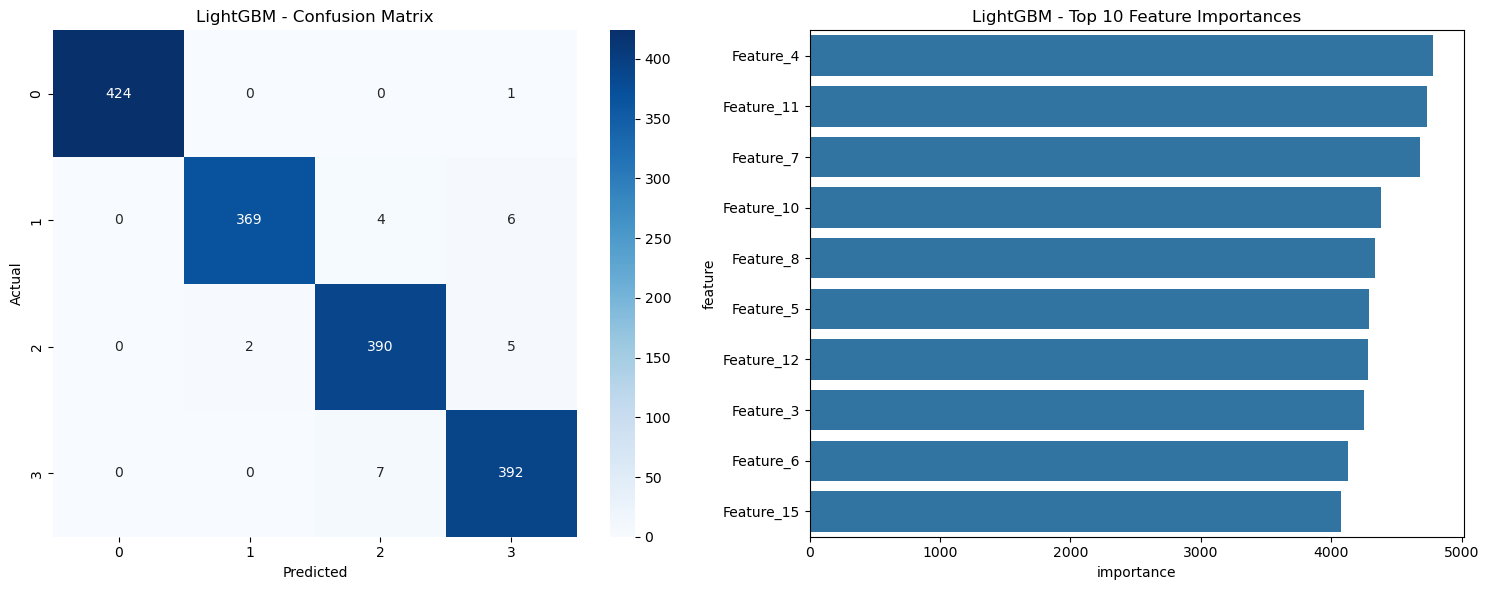

In [9]:
# Confusion Matrix and Feature Importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('LightGBM - Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Feature Importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
    'importance': final_lgb.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', ax=ax2)
ax2.set_title('LightGBM - Top 10 Feature Importances')

plt.tight_layout()
plt.show()

In [10]:
# Save the classification report
report_dict = classification_report(y_test, y_pred_final, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
df.to_csv("performance_metrics/classification_reports/lgbm_report.csv") 

In [11]:
import joblib
# Save the trained model
joblib.dump(final_lgb, 'trained_models/lgbm_model.pkl')
print("LGBM model saved")

LGBM model saved
